# Tópicos Especiais / Feature Extraction and Classification


- Álvaro Ribeiro Fazio
- José Masiero

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from keras.preprocessing import image
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


# Definições Globais

In [45]:
plt.rcParams['figure.figsize'] = [15, 5]

# Diretório raiz do dataset original do trabalho
#IMAGES_ROOT_DIRECTORY = './natural_images_100'

# Diretório raiz do novo dataset do trabalho
IMAGES_ROOT_DIRECTORY = './intel_images_1000'

# Diretório raiz do dataset produzido para o trabalho
NEW_IMAGES_ROOT_DIRECTORY = './new_images'

# Classes consideradas pelo dataset empregado
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Funções de propósito geral

In [3]:
# Leitura das imagens e adição de label
#-----------------------------------------------------------
def read_images_from_folders(data_set_path):
    data_set_images = []
    for dir_name in os.listdir(data_set_path):
        current_dir_name = data_set_path + '/' + dir_name + '/'
        for file_name in os.listdir(current_dir_name):
            data_set_images.append([dir_name,current_dir_name + file_name])
    return data_set_images

# Extracão de features das imagens
#-----------------------------------------------------------
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_as_array = image.img_to_array(img)
    img_as_array = np.expand_dims(img_as_array, axis=0)
    img_as_array = preprocess_input(img_as_array)
    features = model.predict(img_as_array)
    return features

# Carga dos modelos

In [5]:
# Carrega o modelo com alpha 0.5
#-----------------------------------------------------------
model_alpha_0_5 = MobileNet(weights='imagenet', include_top=False, pooling='avg', alpha=0.5)
#model_alpha_0_5.summary()

/home/afazio/opt/anaconda3/envs/pylab/lib/python3.7/site-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Carrega o modelo com alpha 0.75
#-----------------------------------------------------------
model_alpha_0_75 = MobileNet(weights='imagenet', include_top=False, pooling='avg', alpha=0.75)
#model_alpha_0_5.summary()

10633216/10626956 [==============================] - 43s 4us/step


In [9]:
# Carrega o modelo com alpha 1
#-----------------------------------------------------------
model_alpha_1 = MobileNet(weights='imagenet', include_top=False, pooling='avg', alpha=1)
#model_alpha_0_5.summary()

17227776/17225924 [==============================] - 36s 2us/step


# Carga das imagens e "feature extraction" / alpha 0.5

In [11]:
# Carga das imagens
#-----------------------------------------------------------
images = []
for folder,image_path in read_images_from_folders(IMAGES_ROOT_DIRECTORY):
    images.append([folder,image_path,extract_features(image_path,model_alpha_0_5)])

# Separação dos dados de treinamento e validação 

In [12]:
# Dados de treinamento e validação
#-----------------------------------------------------------
images_train, images_test = train_test_split(images, test_size = 0.30, random_state = 64)

images_train_properties = []
images_train_label = []
for a,b,c in images_train:
    images_train_label.append(a)
    images_train_properties.append(c[0].tolist())
    
images_test_properties = []
images_test_label = []
images_test_image_path = []
for a,b,c in images_test:
    images_test_label.append(a)
    images_test_properties.append(c[0].tolist())
    images_test_image_path.append(b)

## SVM

Conisiderei o uso de hiper parâmetros, o que se mostrou uma abordagem ruim, visto que o processamento demando mais de duas e trinta minutos, sendo que o modelo resultante se mostrou inferior, a configuração considerada foi:

`
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'decision_function_shape' : ['ovo','ovr']
             }
`

No que diz respeito ao parâmetro `C`, valor selecionado foi o mesmo empregado por omissão, no caso, `1.0`.

In [13]:
clf_svm = svm.SVC(gamma='scale')
clf_svm.fit(images_train_properties,images_train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Dados de treinamento

In [43]:
images_train_label_pred = clf_svm.predict(images_train_properties)
print(classification_report(images_train_label, images_train_label_pred))

              precision    recall  f1-score   support

   buildings       0.99      0.97      0.98       681
      forest       1.00      0.99      0.99       708
     glacier       0.93      0.94      0.93       702
    mountain       0.93      0.92      0.93       723
         sea       0.98      0.98      0.98       699
      street       0.97      0.99      0.98       687

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



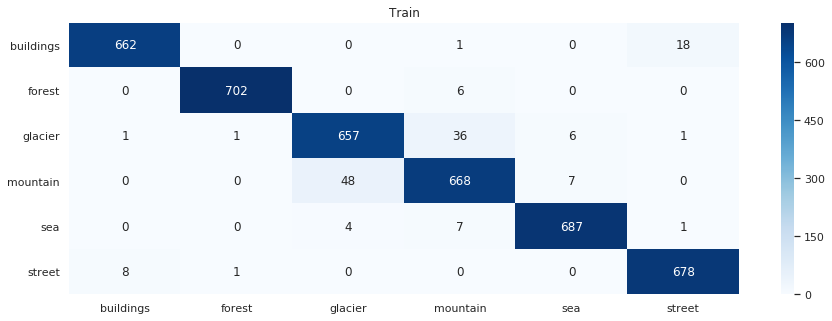

In [15]:
cm = confusion_matrix(images_train_label, images_train_label_pred)
sns.set()
plt.figure()
plt.title('Train')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

### Dados de teste

In [29]:
images_test_label_pred = clf_svm.predict(images_test_properties)
print(classification_report(images_test_label, images_test_label_pred))

              precision    recall  f1-score   support

   buildings       0.93      0.91      0.92       319
      forest       0.99      0.99      0.99       292
     glacier       0.85      0.84      0.84       298
    mountain       0.86      0.84      0.85       277
         sea       0.94      0.97      0.95       301
      street       0.92      0.94      0.93       313

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.92      0.92      0.92      1800



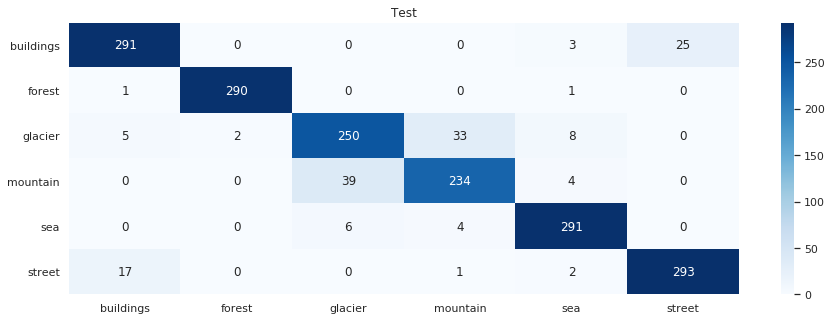

In [17]:
cm = confusion_matrix(images_test_label, images_test_label_pred)
sns.set()
plt.figure()
plt.title('Test')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

forest / forest


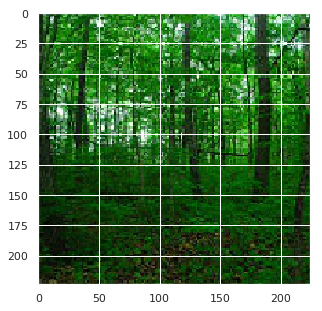

In [21]:
# Apresenta a centésima imagem, o label da imagem e o label previsto
i = 1
print(images_test_label[i] + ' / ' + images_test_label_pred[i])
plt.imshow(image.load_img(images_test_image_path[i], target_size=(224, 224)))

# Decision Tree

In [30]:
clf_dt = tree.DecisionTreeClassifier()
clf_dt.fit(images_train_properties,images_train_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Dados de treinamento

In [37]:
images_train_label_pred = clf_dt.predict(images_train_properties)
print(classification_report(images_train_label, images_train_label_pred))

              precision    recall  f1-score   support

   buildings       1.00      1.00      1.00       681
      forest       1.00      1.00      1.00       708
     glacier       1.00      1.00      1.00       702
    mountain       1.00      1.00      1.00       723
         sea       1.00      1.00      1.00       699
      street       1.00      1.00      1.00       687

    accuracy                           1.00      4200
   macro avg       1.00      1.00      1.00      4200
weighted avg       1.00      1.00      1.00      4200



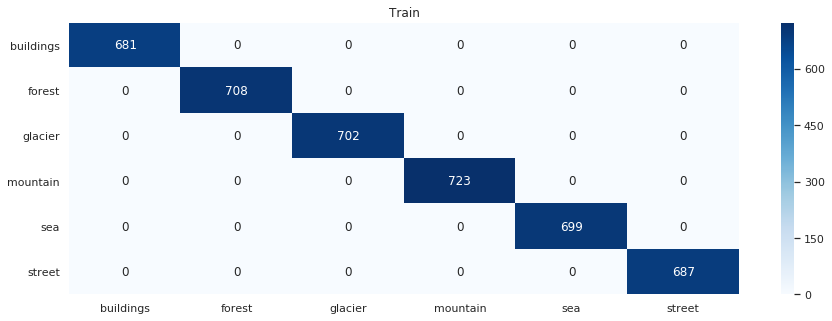

In [41]:
cm = confusion_matrix(images_train_label, images_train_label_pred)
sns.set()
plt.figure()
plt.title('Train')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

### Dados de teste

In [39]:
images_test_label_pred = clf_dt.predict(images_test_properties)
print(classification_report(images_test_label, images_test_label_pred))

              precision    recall  f1-score   support

   buildings       0.78      0.76      0.77       319
      forest       0.93      0.95      0.94       292
     glacier       0.67      0.63      0.65       298
    mountain       0.65      0.71      0.68       277
         sea       0.77      0.75      0.76       301
      street       0.75      0.75      0.75       313

    accuracy                           0.76      1800
   macro avg       0.76      0.76      0.76      1800
weighted avg       0.76      0.76      0.76      1800



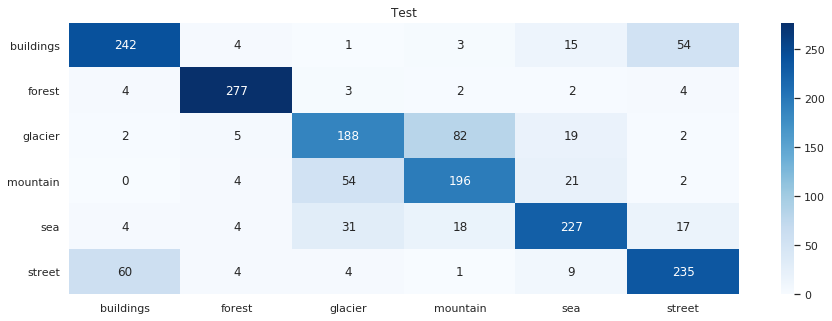

In [42]:
cm = confusion_matrix(images_test_label, images_test_label_pred)
sns.set()
plt.figure()
plt.title('Test')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

sea / sea


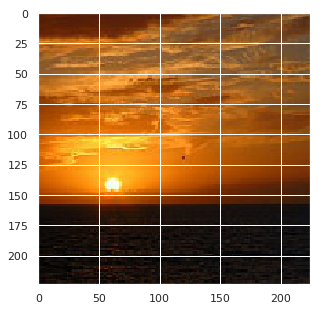

In [36]:
# Apresenta a centésima imagem, o label da imagem e o label previsto
i = 100
print(images_test_label[i] + ' / ' + images_test_label_pred[i])
plt.imshow(image.load_img(images_test_image_path[i], target_size=(224, 224)))

# Comparação de Classificadores

Com relação ao SVM eu busquei a otimização dos parâmetros da função de treinamento pelo uso de hiper parâmetros, o que se mostrou inadequado, em primeiro lugar por que o tempo de treinamento do modelo chegou a quase três horas, e os parâmetros selecionados, em especial `C`, consideraram valores próximos dos defaults, oferecendo ainda um nível de acurácia inferior, tanto para os dados de treinamento como para os dados de teste.

Sobre os dados de treinamento uma acurácia macro de 0.97, sendo que pela perspectiva das classes individuais somente para forest houve uma acurácia de 1.00 (buildins foi 0.99), glacier e montains foram as que pior performaram, com 0.93, sendo que análise da matriz de confusão mostra que os erros mais frequentes estavam associados a montanhas e glaciers - comportamento entre precision, recall e f1-score se mostra consistente entre as classes.

Para os dados de teste a acurácia foi um pouco menor, como esperado, com um valor macro de 0.92, persistindo a premissa de as classes glacier e montains foram as que pior performaram.

Com relação a Decision Tree, sobre os dados de treinamento, o  modelo apresenta claramente um cenário de “over fit”, com uma precisão de 1.0. Já sobre os dados de teste, a questão de erro entre glacier e montains persiste, ao mesmo tempo que a precisão geral do modelo, e também no nível das classes é inferior ao obtido com SVM. O que permite que para os dados considerados, o SVM performou de forma consistente superior.


# Novas imagens

Continua de atrapalhando com `glacier` e `montain`, mas para as demais performou de forma razoável, **é importante ressaltar que busquei escolher imagens mais difíceis**.

In [49]:
# Carga das imagens
#-----------------------------------------------------------
images_new = []
for folder,image_path in read_images_from_folders(NEW_IMAGES_ROOT_DIRECTORY):
    images_new.append([folder,image_path,extract_features(image_path,model_alpha_0_5)])

In [50]:
# Dados de teste
#-----------------------------------------------------------
images_new_properties = []
images_new_label = []
images_new_image_path = []
for a,b,c in images_test:
    images_new_label.append(a)
    images_new_properties.append(c[0].tolist())
    images_new_image_path.append(b)

In [51]:
images_new_label_pred = clf_dt.predict(images_new_properties)
print(classification_report(images_new_label, images_new_label_pred))

              precision    recall  f1-score   support

   buildings       0.78      0.76      0.77       319
      forest       0.93      0.95      0.94       292
     glacier       0.67      0.63      0.65       298
    mountain       0.65      0.71      0.68       277
         sea       0.77      0.75      0.76       301
      street       0.75      0.75      0.75       313

    accuracy                           0.76      1800
   macro avg       0.76      0.76      0.76      1800
weighted avg       0.76      0.76      0.76      1800



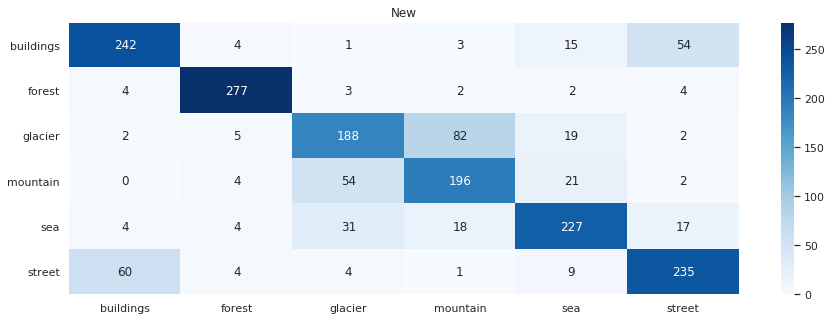

In [53]:
cm = confusion_matrix(images_new_label, images_new_label_pred)
sns.set()
plt.figure()
plt.title('New')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

# Alpha 0.75

In [54]:
# Carga das imagens
#-----------------------------------------------------------
images = []
for folder,image_path in read_images_from_folders(IMAGES_ROOT_DIRECTORY):
    images.append([folder,image_path,extract_features(image_path,model_alpha_0_5)])

In [55]:
# Dados de treinamento e validação
#-----------------------------------------------------------
images_train, images_test = train_test_split(images, test_size = 0.30, random_state = 64)

images_train_properties = []
images_train_label = []
for a,b,c in images_train:
    images_train_label.append(a)
    images_train_properties.append(c[0].tolist())
    
images_test_properties = []
images_test_label = []
images_test_image_path = []
for a,b,c in images_test:
    images_test_label.append(a)
    images_test_properties.append(c[0].tolist())
    images_test_image_path.append(b)

In [56]:
# Treinamento do modelo
#-----------------------------------------------------------
clf_svm = svm.SVC(gamma='scale')
clf_svm.fit(images_train_properties,images_train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
images_train_label_pred = clf_svm.predict(images_train_properties)
print(classification_report(images_train_label, images_train_label_pred))

              precision    recall  f1-score   support

   buildings       0.99      0.97      0.98       681
      forest       1.00      0.99      0.99       708
     glacier       0.93      0.94      0.93       702
    mountain       0.93      0.92      0.93       723
         sea       0.98      0.98      0.98       699
      street       0.97      0.99      0.98       687

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



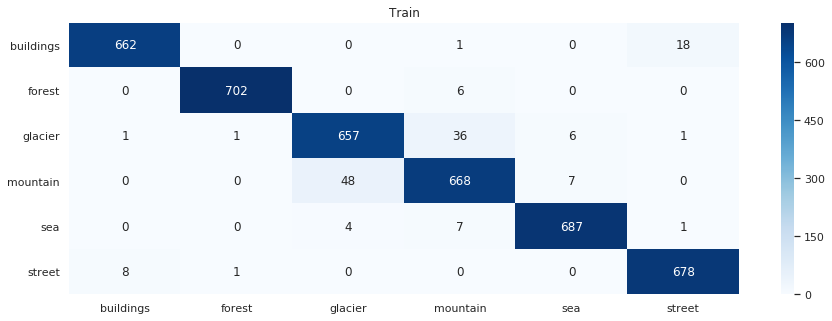

In [58]:
cm = confusion_matrix(images_train_label, images_train_label_pred)
sns.set()
plt.figure()
plt.title('Train')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

In [61]:
images_test_label_pred = clf_svm.predict(images_test_properties)
print(classification_report(images_test_label, images_test_label_pred))

              precision    recall  f1-score   support

   buildings       0.93      0.91      0.92       319
      forest       0.99      0.99      0.99       292
     glacier       0.85      0.84      0.84       298
    mountain       0.86      0.84      0.85       277
         sea       0.94      0.97      0.95       301
      street       0.92      0.94      0.93       313

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.92      0.92      0.92      1800



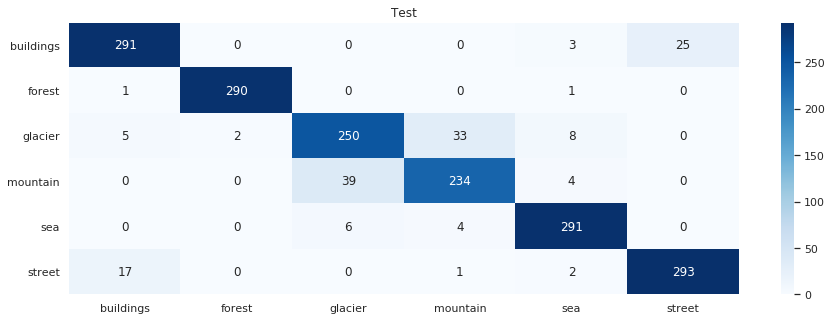

In [62]:
cm = confusion_matrix(images_test_label, images_test_label_pred)
sns.set()
plt.figure()
plt.title('Test')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

# Extra I (experimentação com outra rede)

# Extra II (Experimentar abordagens de agrupamento de dados)